## Trajectory Optimization with Differentiable Simulation

### Imports

In [1]:
import os
from copy import deepcopy
# math
import numpy as np
# optim
import torch
# physics
import warp as wp
import warp.sim as wps
# graphics
import drjit as dr
import mitsuba as mi
from mitsuba.scalar_rgb import Transform4f as mit
# plots
from matplotlib import pyplot as plt
import cv2

# setup
wp.init()
mi.set_variant('llvm_ad_rgb')
print(f'Mitsuba 3 Variant: {mi.variant()}')

Warp 0.15.1 initialized:
   CUDA Toolkit 11.5, Driver 11.4
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA GeForce GTX 1050 Ti with Max-Q Design" (4 GiB, sm_61, mempool enabled)
   Kernel cache:
     /home/jonathan/.cache/warp/0.15.1
Mitsuba 3 Variant: llvm_ad_rgb


### Scene

In [2]:
# camera positioned to view the scene, adjust as needed
cam_pos = np.array([0.0, 1.0, 5.0])  
cam_target = np.array([0.0, 1.0, 0.0])
cam_up = np.array([0.0, 1.0, 0.0])

# particle
particle_init_pos = np.array([-0.5, 2.0, 0.0])
particle_init_vel = np.array([0.0, 0.0, 0.0])
particle_radius = 1.0
particle_mass = 1.0
particle_rgb = np.array([0.2, 0.25, 0.7])

# target
particle_target_vel = np.array([3.0, 0.0, 0.0])
target_pos = np.array([0.7,  1.2114,  0.])

# simulation parameters
sim_duration = 0.4
# control frequency
fps = 60
frame_dt = 1.0 / float(fps)
frame_steps = int(sim_duration / frame_dt)
# sim frequency
sim_substeps = 8
sim_steps = frame_steps * sim_substeps
sim_dt = frame_dt / sim_substeps

### Physics

In [3]:
def build_phys(device, est_names=[], pred_names=[]):
    requires_grad = len(est_names) > 0
    
    builder = wps.ModelBuilder()
    # particle
    builder.add_particle(pos=particle_init_pos, vel=particle_init_vel, radius=particle_radius, mass=particle_mass)
    model = builder.finalize(device, requires_grad=requires_grad)

    # set up states
    states = [model.state(requires_grad=requires_grad) for _ in range(sim_steps + 1)]

    # params being estimated
    est_params = {}
    for name in est_names:
        if name == 'vel':
            est_params[name] = wp.to_torch(states[0].particle_qd)
    
    # params being predicted
    pred_params = {}
    for name in pred_names:
        if name == 'pos':
            pred_params[name] = wp.to_torch(states[-1].particle_q)
            
    return model, states, est_params, pred_params


def capture_phys(device, model, integrator, states):
    # tape tracks computation graph
    tape = wp.Tape()
    wp.capture_begin(device=device)
    with tape:
        for i in range(sim_steps):
            states[i].clear_forces()
            integrator.simulate(model, states[i], states[i + 1], sim_dt)
    graph = wp.capture_end()

    return graph, tape


def get_trajectory(states):
    trajectory = []
    for state in states[::sim_substeps]:
        trajectory.append(state.particle_q.numpy().squeeze())
    return np.array(trajectory)


def distance(target_pose, pred_pose):
    return torch.linalg.norm(target_pose - pred_pose)

### Rendering

In [4]:
img_width = 256
img_height = 256
fov = 60

render_integrator = {
    'type': 'direct_reparam',
}

scene_dict = {
    'type': 'scene',
    'integrator': render_integrator,
    'sensor':  {
        'type': 'perspective',
        'to_world': mit.look_at(
                        origin=cam_pos,
                        target=cam_target,
                        up=cam_up),
        'fov': fov,
        'film': {
            'type': 'hdrfilm',
            'width': img_width,
            'height': img_height,
            'rfilter': { 'type': 'gaussian' },
            'sample_border': True
        },
    },
    "light": {
        "type": "constant"
    },
    'particle': {
        'type': 'sphere',
        'center': particle_init_pos,
        'radius': particle_radius,
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': particle_rgb
            }
        }
    },
    "ground": {
        "type": "rectangle",
        "to_world": mit.rotate(axis=[1.0, 0.0, 0.0], angle=-90).scale(20),
        "bsdf": {
            "type": "diffuse",
            'reflectance': {
                'type': 'checkerboard',
                'to_uv': mi.ScalarTransform4f.scale([10, 10, 1])
            }
        }
    }
}


target_scene_dict = dict(scene_dict)
target_scene_dict['particle']['center'] = deepcopy(target_pos)
target_img = mi.render(mi.load_dict(target_scene_dict), spp=16)

In [5]:
def make_video(scene_dict, states, width, height, fps=60, output_folder="output", video_name="scene.mp4"):
    imgs = []
    for state in states[::sim_substeps]:
        # update scene with current state
        scene_dict['particle']['center'] = state.particle_q.numpy().squeeze()
        scene = mi.load_dict(scene_dict)
        # render the image
        img = mi.render(scene)
        imgs.append(img)

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # assume all images are the same size
    video_fp = os.path.join(output_folder, video_name)
    video = cv2.VideoWriter(video_fp, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for img in imgs:
        bitmap = cv2.cvtColor(np.array(mi.util.convert_to_bitmap(img)), cv2.COLOR_RGB2BGR)
        video.write(bitmap)

    cv2.destroyAllWindows()
    video.release()

### States

In [6]:
# initial run 
phys_device = wp.get_cuda_devices()[0]
phys_model, phys_states, _, phys_pred = build_phys(phys_device, pred_names=['pos'])
phys_integrator = wp.sim.SemiImplicitIntegrator()
phys_graph, _ = capture_phys(phys_device, phys_model, phys_integrator, phys_states)
wp.capture_launch(phys_graph)

Module warp.utils load on device 'cuda:0' took 3.46 ms
Module warp.sim.inertia load on device 'cuda:0' took 11.04 ms
Module warp.sim.model load on device 'cuda:0' took 0.20 ms
Module warp.sim.collide load on device 'cuda:0' took 97.75 ms
Module warp.sim.optimizer load on device 'cuda:0' took 0.94 ms
Module warp.sim.particles load on device 'cuda:0' took 2.84 ms
Module warp.sim.utils load on device 'cuda:0' took 11.73 ms
Module warp.sim.integrator_euler load on device 'cuda:0' took 72.55 ms
Module warp.sim.integrator_xpbd load on device 'cuda:0' took 121.68 ms
Module warp.sim.articulation load on device 'cuda:0' took 39.38 ms


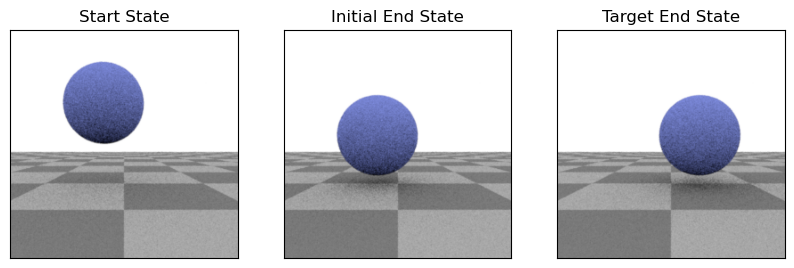

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

init_start_scene_dict = dict(scene_dict)
init_start_scene_dict['particle']['center'] = deepcopy(particle_init_pos)
bitmap_init = mi.util.convert_to_bitmap( mi.render(mi.load_dict(init_start_scene_dict), spp=16))
axs[0].imshow(bitmap_init)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('Start State')


init_end_scene_dict = dict(scene_dict)
init_end_scene_dict['particle']['center'] = deepcopy(phys_pred['pos'].cpu().numpy())
bitmap_init = mi.util.convert_to_bitmap(mi.render(mi.load_dict(init_end_scene_dict), spp=16))
axs[1].imshow(bitmap_init)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Initial End State')


bitmap_target = mi.util.convert_to_bitmap(target_img)
axs[2].imshow(bitmap_target)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title('Target End State')

plt.show()
#plt.savefig('fig_image_traj_states.pdf', bbox_inches='tight')

### Optimization

In [8]:
# training
train_iters = 30
train_rate = 0.1
train_save_interval = 10

# physics
phys_device = wp.get_cuda_devices()[0]
phys_model, phys_states, phys_params, phys_pred = build_phys(phys_device, est_names=['vel'], pred_names=['pos'])
phys_integrator = wp.sim.SemiImplicitIntegrator()
phys_graph, phys_tape = capture_phys(phys_device, phys_model, phys_integrator, phys_states)
phys_target = torch.tensor(target_pos, dtype=torch.float32, device=torch.device('cuda')).unsqueeze(0)

# rendering
vis_device = torch.device('cpu')
vis_dict = dict(scene_dict)
vis_dict['particle']['center'] = np.zeros(3)
vis_scene = mi.load_dict(vis_dict)
vis_spp = 4
vis_params = mi.traverse(vis_scene)
vis_obj_trafo = mi.Transform4f(vis_params['particle.to_world'])
@dr.wrap_ad(source='torch', target='drjit')
def render(trans):
    trans = dr.unravel(mi.Point3f, trans)
    trafo = mi.Transform4f.translate([trans.x, trans.y, trans.z])
    vis_params['particle.to_world'] = trafo @ vis_obj_trafo
    vis_params.update()
    img = mi.render(vis_scene, vis_params, spp=vis_spp)
    return img

# optimization
opt = torch.optim.Adam(list(phys_params.values()), lr=train_rate)
loss = torch.nn.MSELoss(reduction='mean')

# metrics
trajs = []
phys_errors = []
vis_losses = []

for i in range(train_iters+1):
    # zero grads
    opt.zero_grad(set_to_none=False)
    phys_tape.zero()

    # forward pass
    wp.capture_launch(phys_graph)
    vis_pred = render(phys_pred['pos'].to(vis_device))
    vis_output = loss(vis_pred, target_img.torch())

    if i < train_iters:
        # backprop
        vis_output.backward()
        phys_tape.backward(grads={phys_pred['pos'] : phys_pred['pos'].grad})
        opt.step()
        # don't want these to change
        phys_params['vel'].data[0, 1:3] = 0.0
    

    vis_losses.append(vis_output.cpu().detach().numpy())
    phys_error = torch.linalg.norm(phys_pred['pos'] - phys_target).cpu().detach().numpy()
    phys_errors.append(phys_error)
    if i % train_save_interval == 0:
        print(f"iter_{i:02d}: img_loss={vis_losses[-1]:6f}, pose_error={phys_errors[-1]:6f} vel_x={phys_params['vel'][0,0]:.4f}")
        trajs.append(get_trajectory(phys_states))

iter_00: img_loss=0.064242, pose_error=1.200000 vel_x=0.1000
iter_10: img_loss=0.043672, pose_error=0.801334 vel_x=1.0972
iter_20: img_loss=0.021550, pose_error=0.393104 vel_x=2.1201
iter_30: img_loss=0.001262, pose_error=0.018269 vel_x=3.0457


### Result

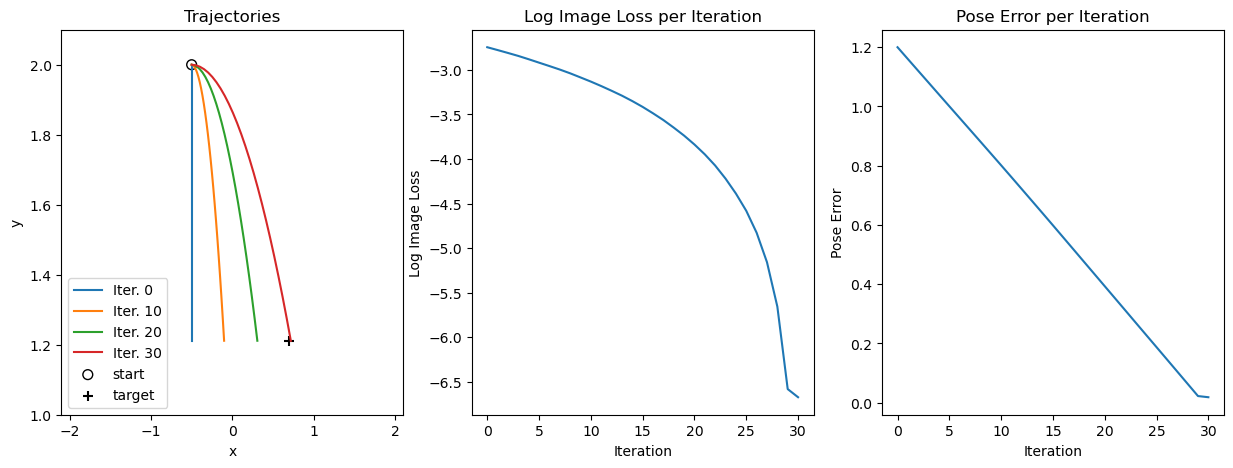

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

################
# Trajectories #
################

axs[0].set_title('Trajectories') 
for i, vel_traj in enumerate(trajs):
    axs[0].plot(vel_traj[:, 0], vel_traj[:, 1], label=f'Iter. {i*train_save_interval}')
axs[0].scatter(particle_init_pos[0], particle_init_pos[1], label='start', facecolors='none', edgecolors='black', s=50)
axs[0].scatter(target_pos[0], target_pos[1], color='black', label='target', marker='+', s=50)
axs[0].set_xlim([-2.1, 2.1])
axs[0].set_ylim([1.0, 2.1])
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].legend(loc='lower left')


###################
# Losses / Errors #
###################

axs[1].plot(np.log(vis_losses))
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Log Image Loss')
axs[1].set_title('Log Image Loss per Iteration')

axs[2].plot(phys_errors)
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Pose Error')
axs[2].set_title('Pose Error per Iteration')

plt.show()
#plt.savefig('fig_image_traj_optim.pdf', bbox_inches='tight')

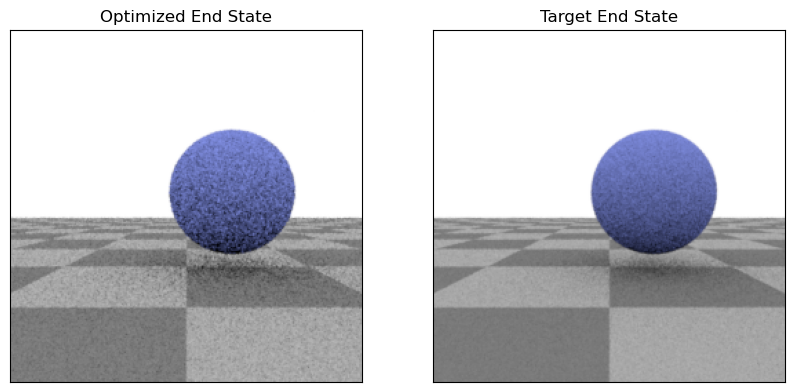

In [10]:
##########
# States #
##########
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(mi.util.convert_to_bitmap(vis_pred))
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('Optimized End State')

axs[1].imshow(bitmap_target)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Target End State')
plt.show()